Vamos a cargar el archivo de hoja de calculo para revisar el dataset existente

In [1]:
import re

import pytz as tz
from datetime import datetime

import numpy as np
np.random.seed(1337)

import xlrd

import pandas as pd

Activar graficador en linea con parametros predeterminados para los graficos a generarse

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

In [9]:
import os
import shutil

datadir = '../data'

In [10]:
filename = os.path.join(datadir, 'default of credit card clients.xls')

In [11]:
df = pd.read_excel(filename, header=1)

Revisar las columnas que tiene el archivo, excepto la columna ID que no aporta nada para el modelo

In [12]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

Variables:\
limit_bal cantidad de credito concedido al cliente\
sex masculino, femenino\
education 1 = colegio, 2 = universidad, 3 = instituto, 4 = otros\
marriage 1 = casado, 2 = soltero, 3 = otros\
age edad en años\
pay_1 a 6 historial de pagos, cantidad de meses de retraso, valores negativos cantidad de meses que se anticipa, 0 pago el mes que le correponde, valores mayores a cero los meses que se retraso en el pago\
bill_amt1 a 6 valor a pagar en cada uno de los ultimos meses\
pay_amt1 a 6 valor pagado en cada uno de los meses\
default payment next month 0 = pago en el siguiente mes, 1 = no pago en el siguiente mes

In [13]:
print("Numero de variables:  {}".format(len(df.columns)-1))
print("Numero de observaciones: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# La prediccion se hace sobre la columnas 'target' 1 impago, 0 pago
print("Variable objetivo:       '{}' -> '{}'".format('default payment next month', 'target'))

Numero de variables:  23
Numero de observaciones: 30000
Variable objetivo:       'default payment next month' -> 'target'


In [14]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

df[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,-1,-1,0,0,-1
8,0,0,2,0,0,0
9,-2,-2,-2,-2,-1,-1


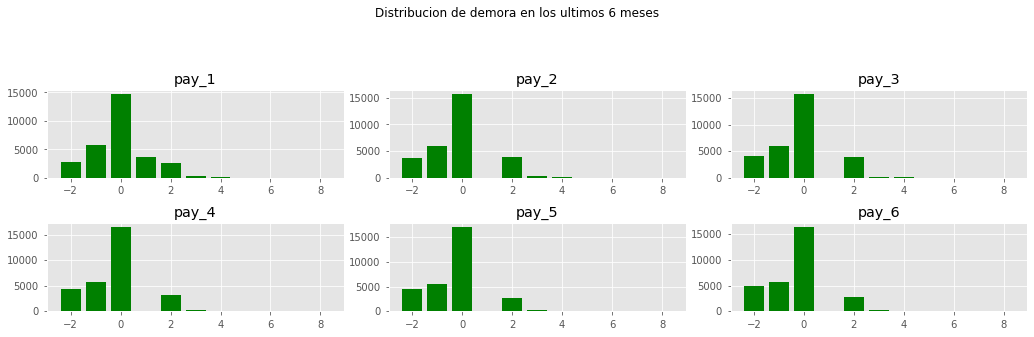

In [15]:
# pay status columns
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribucion de demora en los ultimos 6 meses')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

Se puede observar que hay varios pagos realizados con dos meses de retraso

Operaciones que caen en impago 22.12% de 30000 observaciones


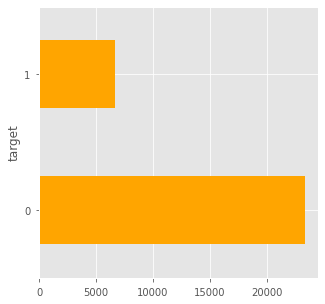

In [16]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()

print("Operaciones que caen en impago {}% de {} observaciones".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')

Se procede a etiquetar o categorizar las variables sex, marriage, age

In [17]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])

In [18]:
df['age_cat'] = pd.cut(df['age'], range(0, 100, 5), right=False)

In [19]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
for i in pay_status_columns:
    df[i] = df[i].astype('category')

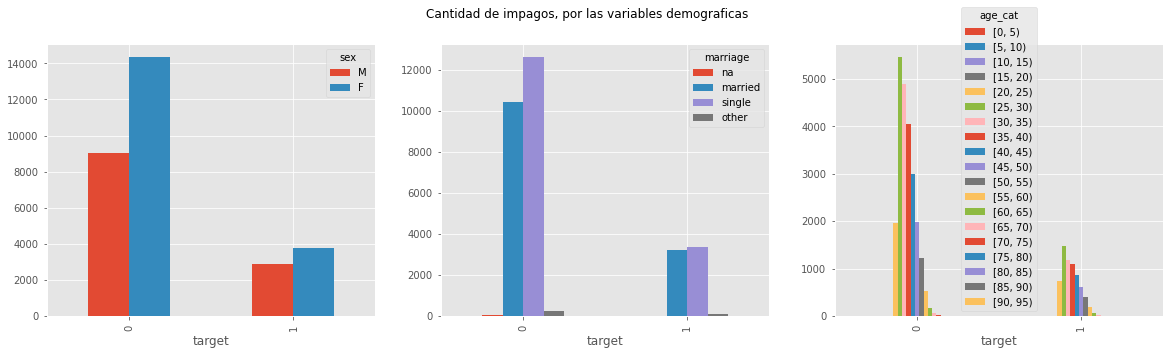

In [20]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Cantidad de impagos, por las variables demograficas')

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

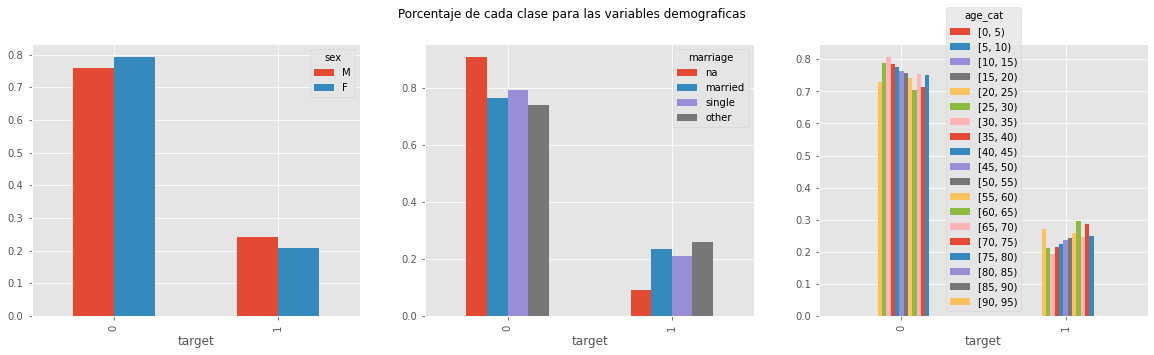

In [21]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Porcentaje de cada clase para las variables demograficas')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

Para no cesgar a valores de cero y uno, se va a aplicar conversiones logaritmicas